# querying for ranges at event times
Tim Tyree<br>
10.8.2021

In [1]:
from lib.my_initialization import *
from lib import *
# from lib.measure.unwrap_and_smooth_cu import *
# from lib.rapids_func import *
# .routines.unwrap_and_smooth_trajectories_cu import *

import itertools
import dask_cudf
from lib.rapids_func import *

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

import cupy as cp, cudf, numba.cuda as cuda
import rmm
# Switch to RMM allocator
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

Automatic calling is: Smart


In [2]:
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [3]:
#TODO: wouter's query

In [83]:
# input_fn=search_for_file()
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/trajectories/ic200x200.1.1_traj_sr_600_mem_0.csv'
input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/trajectories/ic200x200.0.1_traj_sr_600_mem_0.csv'

In [84]:
width=200
height=200
ds=5 #cm
DS=ds/width

In [110]:
distance_L2_pbc=get_distance_L2_pbc(width,height)
round_t_to_n_digits=7
DT = get_DT_cu(df)  #ms
DT

0.025

In [188]:
def routine(input_fn):
    df = cudf.read_csv(input_fn)
    df['t'] = cp.around(df['t'], round_t_to_n_digits)  #fixes machine error
    #assign unique identifier to this event
    event_id_int = float(
        '1' + (''.join(re.findall(r'-?\d+\d*', os.path.basename(input_fn)))))
    df['event_id_int'] = int(event_id_int)
    n_series = (df.groupby('t')['n'].mean().astype('int').sort_index())

    #identify time points where 2->4
    boo = (n_series.diff() == 2).shift(-1) & (n_series == 2)
    times_2_then_4 = boo[boo].index.values.get()

    index1_lst = []
    index2_lst = []
    R_birth_lst = []
    t_lst = []
    for t in times_2_then_4:
        dff2 = df.loc[df['t'] == t, ['event_id_int', 'particle', 'x', 'y']]
        dff4 = df.loc[(cp.isclose(df['t'], t + DT, rtol=1e-10)),#&(df['n']==4)),
                      ['event_id_int', 'particle', 'x', 'y']]
        #compute ranges for new particles
        new_pid = sorted(
            set(dff4['particle'].values.get()).difference(
                dff2['particle'].values.get()))
        point1 = dff4.loc[dff4['particle'] == new_pid[0],
                          ['x', 'y']].values.get().flatten()
        point2 = dff4.loc[dff4['particle'] == new_pid[1],
                          ['x', 'y']].values.get().flatten()
#         index1 = dff4.loc[dff4['particle'] == new_pid[0]].index.values.get()
#         index2 = dff4.loc[dff4['particle'] == new_pid[1]].index.values.get()
        index1 = int(dff4.loc[dff4['particle'] == new_pid[0]].index.values.get())
        index2 = int(dff4.loc[dff4['particle'] == new_pid[1]].index.values.get())
        R_birth = distance_L2_pbc(point1, point2) * DS  #cm
        #record
        index1_lst.append(index1)
        index2_lst.append(index2)
        R_birth_lst.append(R_birth)
        t_lst.append(t)

    df_2_to_4 = pd.DataFrame({
        'R_birth': R_birth_lst,
        't': t_lst,
        'event_id_int': event_id_int,
        'index1': index1_lst,
        'index2': index2_lst,
    }).astype({'event_id_int': 'int64', 'index1': 'int32','index2': 'int32'})

    #DONE: identify time points where 2->4
    #DONE: identify the novel/remaining particles
    #DONE: compute the distance between them
    #DONE: repeat for when #identify time points where 4->2

    #identify time points where 4->2
    boo = (n_series.diff() == -2) & (n_series == 2)
    times_4_then_2 = boo[boo].index.values.get()
    times_4_then_2

    index1_lst = []
    index2_lst = []
    R_gone_lst = []
    index1_lst2 = []
    index2_lst2 = []
    R_stay_lst = []
    t_lst = []
    for t in times_4_then_2:
        dff2 = df.loc[df['t'] == t, ['event_id_int', 'particle', 'x', 'y']]
        dff4 = df.loc[(cp.isclose(df['t'], t - DT, rtol=1e-10)),#]&(df['n']==4)),
                      ['event_id_int', 'particle', 'x', 'y']]
        #compute ranges for annihilating particles
        gone_pid = sorted(
            set(dff4['particle'].values.get()).difference(
                dff2['particle'].values.get()))
        point1 = dff4.loc[dff4['particle'] == gone_pid[0],
                          ['x', 'y']].values.get().flatten()
        point2 = dff4.loc[dff4['particle'] == gone_pid[1],
                          ['x', 'y']].values.get().flatten()
#         index1 = dff4.loc[dff4['particle'] == gone_pid[0]].index.values.get()
#         index2 = dff4.loc[dff4['particle'] == gone_pid[1]].index.values.get()
        index1 = int(dff4.loc[dff4['particle'] == gone_pid[0]].index.values.get())
        index2 = int(dff4.loc[dff4['particle'] == gone_pid[1]].index.values.get())
        R_gone = distance_L2_pbc(point1, point2) * DS  #cm

        #record
        index1_lst.append(index1)
        index2_lst.append(index2)
        R_gone_lst.append(R_gone)
        t_lst.append(t)

        #compute ranges for remaining particles
        stay_pid = sorted(dff2['particle'].values.get())
        point1 = dff4.loc[dff4['particle'] == stay_pid[0],
                          ['x', 'y']].values.get().flatten()
        point2 = dff4.loc[dff4['particle'] == stay_pid[1],
                          ['x', 'y']].values.get().flatten()
#         index1 = dff4.loc[dff4['particle'] == stay_pid[0]].index.values.get()
#         index2 = dff4.loc[dff4['particle'] == stay_pid[1]].index.values.get()
        index1 = int(dff4.loc[dff4['particle'] == stay_pid[0]].index.values.get())
        index2 = int(dff4.loc[dff4['particle'] == stay_pid[1]].index.values.get())
        R_stay = distance_L2_pbc(point1, point2) * DS  #cm

        #record
        index1_lst2.append(index1)
        index2_lst2.append(index2)
        R_stay_lst.append(R_stay)

    df_4_to_2 = pd.DataFrame({
        'R_stay': R_stay_lst,
        'R_gone': R_gone_lst,
        't': t_lst,
        'event_id_int': event_id_int,
        'index1_stay': index1_lst2,
        'index2_stay': index2_lst2,
        'index1_gone': index1_lst,
        'index2_gone': index2_lst,
    }).astype({'event_id_int': 'int64', 'index1_stay': 'int32','index2_stay': 'int32',
                                        'index1_gone': 'int32','index2_gone': 'int32'})
    return df_2_to_4, df_4_to_2

In [189]:
input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='.csv')
print(f'computing ranges at 2->4 and 4->2 events for {len(input_fn_lst)} trajectory files from\n{os.path.dirname(input_fn)}')

computing ranges at 2->4 and 4->2 events for 324 trajectory files from
/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/trajectories


In [190]:
npartitions=os.cpu_count()
printing=True

In [191]:
#all CPU version
b = db.from_sequence(input_fn_lst, npartitions=npartitions).map(routine)
start = time.time()
retval = list(b)
if printing:
    print(f"run time for computation was {time.time()-start:.2f} seconds.")

run time for computation was 52.97 seconds.


In [192]:
retval_array=np.array(retval,dtype=object)
retval_array.shape

(324, 2)

In [217]:
df_2_to_4=pd.concat(retval_array[:,0])
df_2_to_4

,R_birth,t,event_id_int,index1,index2
0,0.023579,639.825,12002003556000,120629,120630
1,0.045014,780.800,12002003556000,144465,144466
0,0.033323,532.500,12002001516000,77707,77708
1,0.004324,593.800,12002001516000,83297,83295
2,0.030411,1171.475,12002001516000,177432,177431
...,...,...,...,...,...
0,0.023187,311.675,12002003106000,105816,105817
1,0.085401,487.150,12002003106000,123543,123544
2,0.003173,1191.725,12002003106000,221879,221881
3,0.014758,1217.825,12002003106000,226806,226807


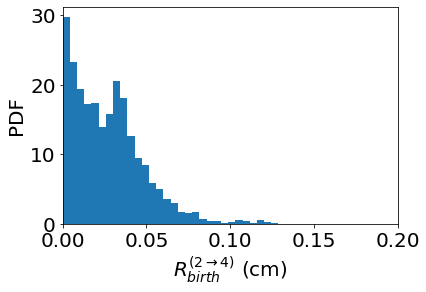

In [226]:
plt.hist(df_2_to_4['R_birth'].values,bins=30,density=True)
format_plot(ax=plt.gca(), xlabel=r'$R_{birth}^{(2\rightarrow4)}$ (cm)', ylabel='PDF', fontsize=20)
plt.xlim([0,0.2])
plt.show()

__Results__
- the range of the newly created particles appears bimodal (N=2047 events)
- the range of the newly created particles appears bimodal both (i) when considering all 2->4 events and (ii) when considering only (2->4) events that occur later than t=4.5 seconds
- the distributions of ranges of remaining particles after a 4->2 event (N=2365) appear qualitatively similar to those of all ranges between all particles at all times... If you want, I can perform a statistical test to see if the distributions are 

- these creation and annihilation distributions were significantly different according to a two-sample Kolmogorov-Smirnov test for goodness of fit (p=5.249127117412655e-07)

In [215]:
# tmin=df_2_to_4['t'].quantile(0.8);print(f"tmin={tmin} ms")
# plt.hist(df_2_to_4.query(f't>={tmin}')['R_birth'].values,bins=30,density=True)
# format_plot(ax=plt.gca(), xlabel=r'$R_{creation}^{(2\rightarrow4)}$ (cm)', ylabel='PDF', fontsize=20)
# plt.show()

In [218]:
df_4_to_2=pd.concat(retval_array[:,1])
# df_4_to_2.head()

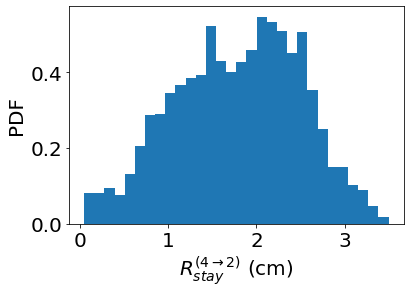

In [219]:
plt.hist(df_4_to_2['R_stay'].values,bins=30,density=True)
format_plot(ax=plt.gca(), xlabel=r'$R_{stay}^{(4\rightarrow2)}$ (cm)', ylabel='PDF', fontsize=20)
plt.show()

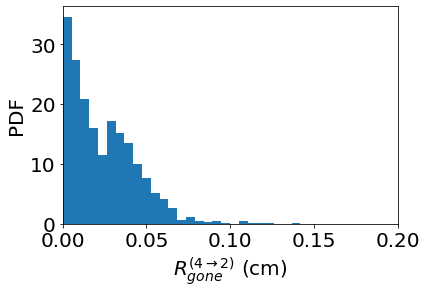

In [225]:
plt.hist(df_4_to_2['R_gone'].values,bins=40,density=True)
format_plot(ax=plt.gca(), xlabel=r'$R_{gone}^{(4\rightarrow2)}$ (cm)', ylabel='PDF', fontsize=20)
plt.xlim([0,0.2])
plt.show()

In [221]:
#DONE: identified bug
#DONE: reproduce erroneous behavior
#DONE: fix bug in multiple rows matching in df_2_to_4 for index1 and index2 retrieval
#DONE: verify that the bug is gone (true if int(...) works)

In [222]:
df_4_to_2

,R_stay,R_gone,t,event_id_int,index1_stay,index2_stay,index1_gone,index2_gone
0,1.503694,0.022295,439.725,12002003556000,104614,104615,104617,104616
1,0.940460,0.008984,766.750,12002003556000,143335,143334,143336,143337
2,0.373077,0.011420,781.650,12002003556000,144593,144592,144594,144595
0,2.928500,0.051299,166.325,12002001516000,48406,48407,48408,48409
1,2.317649,0.003074,541.075,12002001516000,79070,79073,79072,79071
...,...,...,...,...,...,...,...,...
1,1.451637,0.029859,357.800,12002003106000,113190,113191,113189,113188
2,2.418702,0.028078,814.675,12002003106000,191708,191711,191710,191709
3,2.028194,0.006256,1217.775,12002003106000,226794,226797,226795,226796
4,1.237123,0.010520,1255.975,12002003106000,232903,232902,232900,232901


In [231]:
s1=df_4_to_2['R_gone'].values
s2=df_2_to_4['R_birth'].values
scipy.stats.kstest(s1,s2,mode='exact')


KstestResult(statistic=0.08285584741657724, pvalue=5.249127117412655e-07)

In [233]:
#save ranges as pdf
save_folder=os.path.dirname(os.path.dirname(input_fn))
os.chdir(save_folder)

In [234]:
df_4_to_2.to_csv('ranges_4_to_2.csv',index=False)
df_2_to_4.to_csv('ranges_2_to_4.csv',index=False)